# Progetto 2021

# Scaricamento Dataset

Iniziamo con scaricare il Dataset dal seguente Link

In [ ]:
!wget  https://owncloud.cs.icar.cnr.it/owncloud/index.php/s/gEC5TS5FeGtrt8x/download

--2021-06-14 08:45:40--  https://owncloud.cs.icar.cnr.it/owncloud/index.php/s/gEC5TS5FeGtrt8x/download
Resolving owncloud.cs.icar.cnr.it (owncloud.cs.icar.cnr.it)... 150.145.63.148
Connecting to owncloud.cs.icar.cnr.it (owncloud.cs.icar.cnr.it)|150.145.63.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7021620066 (6.5G) [application/x-compressed]
Saving to: ‘download’

download            100%[===================>]   6.54G  6.79MB/s    in 11m 34s 

2021-06-14 08:57:15 (9.65 MB/s) - ‘download’ saved [7021620066/7021620066]



In [ ]:
!cp progetto_2021_dataset/unlabeled1 -r  /content/drive/MyDrive/progetto_2021_datasetUnlabled1

In [ ]:
!cp progetto_2021_dataset -r  /content/drive/MyDrive/progetto_2021_datasetPulito

Importiamo tutte le librerie che verranno utilizzate all'iterno di questo Notebook

In [5]:
SEED = 9246


import os
import json
import time
from datetime import datetime
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models
import warnings
import os, shutil
import pickle
from imutils import paths
import cv2
import sys
from skimage import io, color
import pickle

from PIL import Image

from skimage import io
import pandas as pd
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report

import torchsummary

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")

if CUDA:
    print('run on cuda')


warnings.filterwarnings("ignore")

In [6]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Dataset

In [7]:
DATASET_DIR = '/content/drive/MyDrive/ProgettoAnalisiImmagini/progetto_2021_dataset'

DRIVE_FOLDER = '/content/drive/MyDrive/ProgettoAnalisiImmagini/progetto_2021_saves/model_checkpoint'


JSON_DATA = os.path.join(DATASET_DIR, 'train_test_split_dict.json')

with open(JSON_DATA) as fp:
    dataset_json = json.load(fp)


In [8]:
if not os.path.exists(DRIVE_FOLDER):
  os.mkdir("/content/drive/MyDrive/ProgettoAnalisiImmagini/progetto_2021_saves")
  os.mkdir("/content/drive/MyDrive/ProgettoAnalisiImmagini/progetto_2021_saves/model_checkpoint")

MODELFILE = os.path.join(DRIVE_FOLDER, 'model.pth')

CHECKPOINT = os.path.join(DRIVE_FOLDER, 'model.checkpoint')
CHECKPOINTLoss = os.path.join(DRIVE_FOLDER, 'traningLosses')
CHECKPOINTDizTrain = os.path.join(DRIVE_FOLDER, 'dizionarioFeatureTrain')
CHECKPOINTDizTest = os.path.join(DRIVE_FOLDER, 'dizionarioFeatureTest')



def save_dizFeature(dizFeature,train):
  if train:
    torch.save(dizFeature, CHECKPOINTDizTrain)
    print("!!DIZIONARIO TRAIN FEATURE SALVATO!!")
  else:
    torch.save(dizFeature, CHECKPOINTDizTest)
    print("!!DIZIONARIO TEST FEATURE SALVATO!!")


    
def load_dizFeature(train):
  if train:
    if not os.path.exists(CHECKPOINTDizTrain):
        return None
    return torch.load(CHECKPOINTDizTrain)  
  else:
    if not os.path.exists(CHECKPOINTDizTest):
        return None
    return torch.load(CHECKPOINTDizTest)  




def save_traningLoss(traningLossModel):
    torch.save({
            'traningLossesModel': traningLossModel
            }, CHECKPOINTLoss)
    print(" !!Traning Loss Salvata!!")
    
  


def load_traningLoss():
    if not os.path.exists(CHECKPOINTLoss):
        return None
    traninglossModel = torch.load(CHECKPOINTLoss)['traningLossesModel']
    return traninglossModel

    

def save_checkpoint(epoch, model, optimizer, loss):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, CHECKPOINT)
    

def load_checkpoint(model, optimizer):
    if not os.path.exists(CHECKPOINT):
        return None, None
    checkpoint = torch.load(CHECKPOINT)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    return epoch, loss

def save_model(model):
    torch.save(model.state_dict(), MODELFILE)
    print("Modello Salvato")


def load_model(model):
    if os.path.exists(MODELFILE):
        model.load_state_dict(torch.load(MODELFILE))



def load_ImgMigliori():
  if os.path.exists("/content/drive/MyDrive/ProgettoAnalisiImmagini/progetto_2021_saves/cacheDatasetTrain"):
    return "/content/drive/MyDrive/ProgettoAnalisiImmagini/progetto_2021_saves/cacheDatasetTrain"
          

  return None

## Bilanciamento delle Classi

In questa sezione andremo ad analizzare tutto il Dataset e a descrivere le operazioni di Data Augmentation scelte.

Costruiamo Label_idx che viene utilizzato per mantenere tutte le etichette del nostro Dataset

In [9]:
labels = set()
#Numero tag 85


for k in dataset_json.values():
    for lable_list in k.values():
        for v in lable_list:
            labels.add(v)

            


            
label_idx = {v: i for i, v in enumerate(sorted(labels))}







In [ ]:
print("Numero Classi/Tag",len(label_idx))

Numero Classi/Tag 85


Analizziamo il grafico (Numero Trailer X Tag) .
Per verificare a quanti trailer è associato un particolare tag e quindi renderci conto se siamo in presenza di un dataset sbilanciato o meno

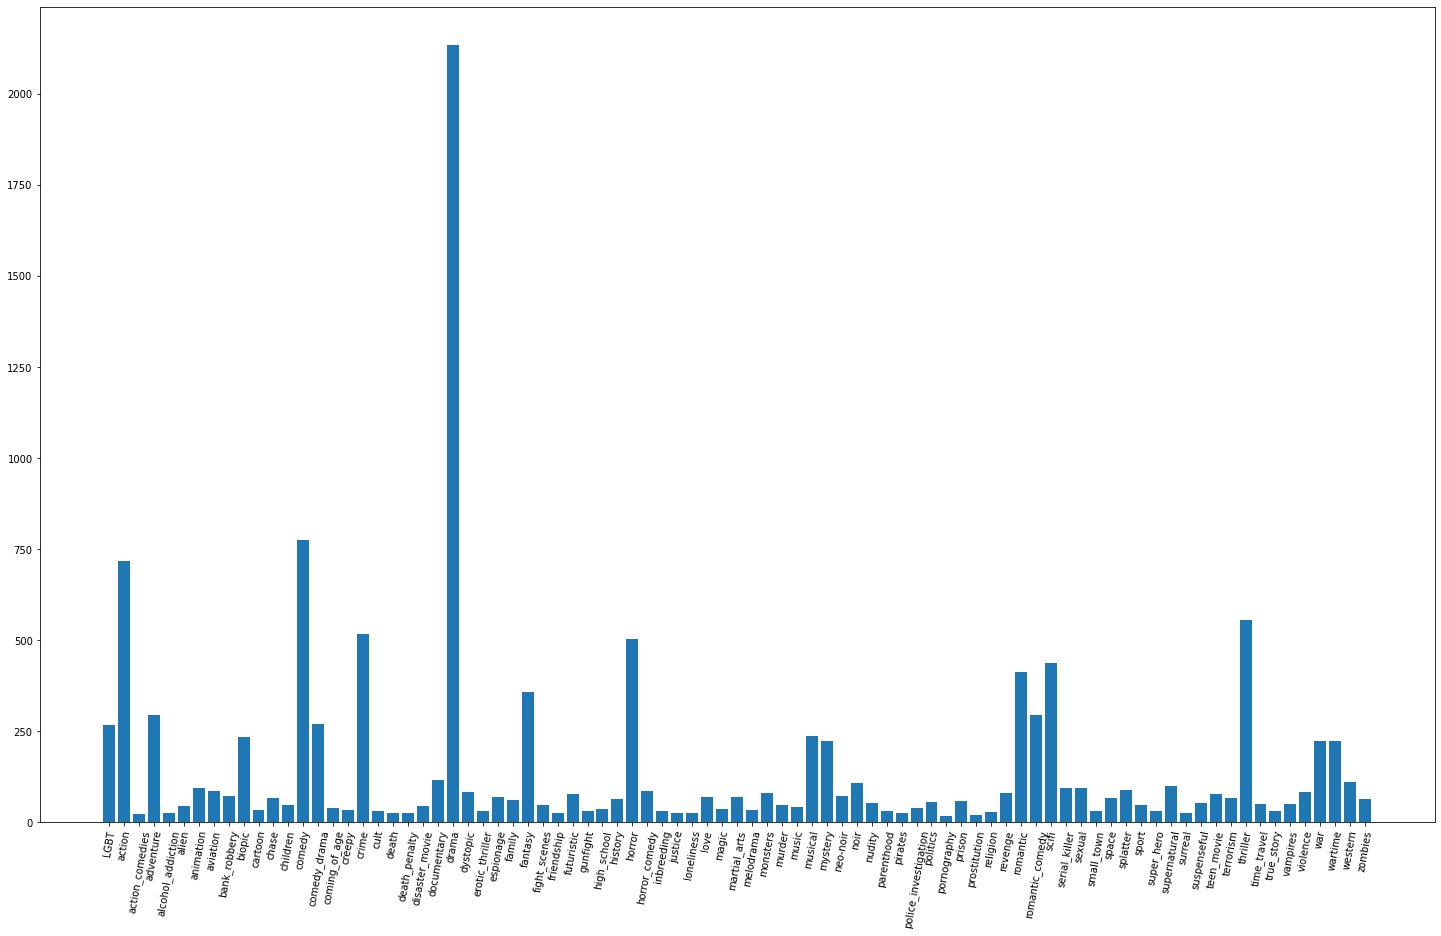

In [10]:
files=np.array(list(dataset_json['train'].keys()))
diz=dataset_json['train']
totale=torch.zeros(len(label_idx), dtype=torch.float32)
for name in files:
  labels = torch.zeros(len(label_idx), dtype=torch.float32)
  for label in diz[name]:
    labels[label_idx[label]] = 1
  totale+=labels




etichette=np.array(list(label_idx.keys()))



plt.figure(figsize=(25,15))
plt.bar(etichette,totale)
plt.xticks(rotation=80)
plt.show()



Come si nota abbiamo molto sbilanciamento tra le classi come ad esempio

1.   Drama che è assegnata a piu di 2000 trailer
2.   Justince,Cult,death,action_comedies a meno di 10

Visto ciò abbiamo deciso di cercare di alleviare lo sbilanciamento sottocampionando la classe maggioritaria (undersampling)

Quindi individuamo la classe maggioritaria che in questo caso è "**drama**" e la portiamo da 2000 trailer a 755 trailer. Come avviene l'eliminazione?
Si cercando prima tutti i trailer che hanno associato solamente come tag "drama" e si eliminano completamente dal dizionario.
In seguito se ci sono ancora tag da eliminare si vanno a trovare i trailer che contengono il tag "drama" nell'insieme dei suoi tag e si elimina solamente il tag e non il trailer.


In [11]:
dizio=dataset_json['train']

newDiz=dict(dizio)

EtichetteDaFare=np.array(etichette[totale>2000])

ContEtichettaDaFare=np.array(totale[totale>2000])

ContEtichettaDaFare=ContEtichettaDaFare-755





for i in range(0,len(EtichetteDaFare)):
  for c in list(newDiz.keys()):
    if EtichetteDaFare[i] in newDiz[c] and len(newDiz[c])==1 and ContEtichettaDaFare[i]>0:
      newDiz.pop(c)
      ContEtichettaDaFare[i]-=1
  


    
  for c in list(newDiz.keys()):
    if EtichetteDaFare[i] in newDiz[c] and len(newDiz[c])>1 and ContEtichettaDaFare[i]>0:
      new=[]
      for eti in newDiz[c]:
        if eti==EtichetteDaFare[i]:
          continue
        new.append(eti)
      newDiz[c]=new
      ContEtichettaDaFare[i]-=1



     












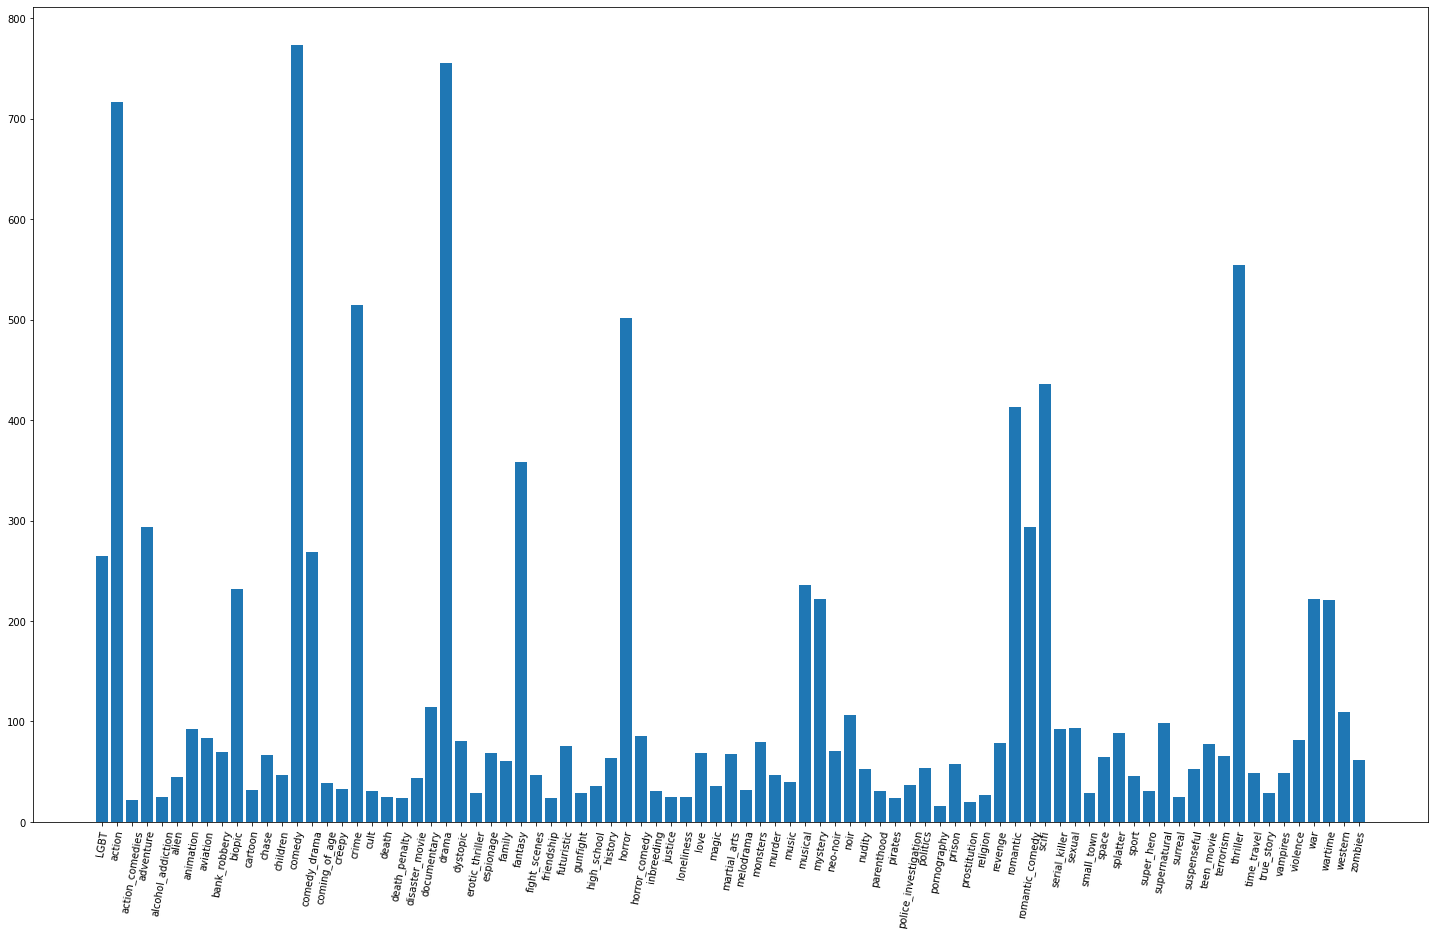

In [12]:
files=np.array(list(newDiz.keys()))
diz=newDiz
totale=torch.zeros(len(label_idx), dtype=torch.float32)
for name in files:
  labels = torch.zeros(len(label_idx), dtype=torch.float32)
  for label in diz[name]:
    labels[label_idx[label]] = 1
  totale+=labels




etichette=np.array(list(label_idx.keys()))


plt.figure(figsize=(25,15))
plt.bar(etichette,totale)
plt.xticks(rotation=80)
plt.show()


Abbiamo riplottato il grafico per vedere se le operazioni fatte precedentemente sono andate a buon fine. E si può vedere che il dataset adesso è molto più bilanciato

## Eliminazione Immagini Rumorose

Facciamo pulizia delle immagini che hanno una maggioranza di colore su un canale R,G,B rispetto all'altro. Per individuare cosi le immagini con scritte o di pubblicità. Ed inoltre eliminiamo anche le immagini che sono molto sfocate per permettere alla nostra rete neurale di analizzare solamente immagini di buona qualità

Per trovare le **immagini pubblicitarie** o con scritte abbiamo  calcolato la media dei valori per ogni immagini su ciascun canale e fatto la differenza con ciascuno di essi. Trovata la differenza maggiore siamo andati a confrontala con una soglia scelta opportunamente di 85.


Per trovare le immagini **sfocate** invece abbiamo utilizzato la varianza del laplaciano , perchè tramite alcune ricerche in letteratura abbiamo notato che essa ci permette di cacolare il valore di sfocatura di un'immagine. Una volta calcolato per ciascuna anche qui lo andiamo a confrontare con una soglia di 11.5

In [ ]:
def variance_of_laplacian(image):
  return cv2.Laplacian(image, cv2.CV_64F).var()

In [ ]:
cartelle=os.listdir(DATASET_DIR)
soglia=85 #valore di soglia per l'immagine omogeenee
thresh=11.5 #valore di soglia per la sfocatura

k=1

 
contImgSfocate=5
contImgOmogenee=5

immaginiProcessate=0

immaginiSfocateEliminate=0
immaginiOmogeneeEliminate=0

listaOmogenee=[]
listaSfocate=[]

for c in cartelle:
  if os.path.isfile(DATASET_DIR+"/"+c):
    continue
  listaImg=os.listdir(DATASET_DIR+"/"+c)
  
  for img in listaImg:
    image = cv2.imread(DATASET_DIR+"/"+c+"/"+img)

    immaginiProcessate+=1
    
    
    #per stampare un trace delle immagini processate
    if immaginiProcessate%1000 ==0:
      print(immaginiProcessate)
      print("Immagini Omogenee eliminate: ",immaginiOmogeneeEliminate)
      print("Immagini Sfocate eliminate: ",immaginiSfocateEliminate)
    
    if image is None:
      continue

    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    

    #INDIVIDUA IMMAGINI CON SCRITTE E PUBBLICITA'
    ar = np.asarray(image)
    r=np.average(ar[:,:,0])
    g=np.average(ar[:,:,1])
    b=np.average(ar[:,:,2])

    

    if r-g >soglia or r-b>soglia:
      
      if contImgOmogenee>0:
        listaOmogenee.append(ar)
        contImgOmogenee-=1

      #plt.figure(k)
      #plt.imshow(ar)
      #plt.show()
      #k+=1

      #os.remove(DATASET_DIR+"/"+c+"/"+img)
      immaginiOmogeneeEliminate+=1
      continue
    

    elif g-r >soglia or g-b>soglia:

      if contImgOmogenee>0:
        listaOmogenee.append(ar)
        contImgOmogenee-=1

      #plt.figure(k)
      #plt.imshow(ar)
      #plt.show()
      #k+=1

      #os.remove(DATASET_DIR+"/"+c+"/"+img)
      immaginiOmogeneeEliminate+=1
      continue
     
    elif b-r >soglia or b-g>soglia:

      if contImgOmogenee>0:
        listaOmogenee.append(ar)
        contImgOmogenee-=1

      #plt.figure(k)
      #plt.imshow(ar)
      #plt.show()
      #k+=1

      #os.remove(DATASET_DIR+"/"+c+"/"+img)
      immaginiOmogeneeEliminate+=1
      continue


    #INDIVIDUA IMMAGINI SFOCATE
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    fm = variance_of_laplacian(gray)
 
    if fm < thresh:
        if contImgSfocate>0:
          listaSfocate.append(image)
          contImgSfocate-=1
        #os.remove(DATASET_DIR+"/"+c+"/"+img)
        immaginiSfocateEliminate+=1
        #plt.figure(k)
        #plt.imshow(ar)
        #plt.show()
        #k+=1

In [ ]:
print("Sono state eliminate: ",immaginiOmogeneeEliminate," immagini omogenee")
print("Sono state eliminate: ",immaginiSfocateEliminate," immagini sfocate")

Sono state eliminate:  2387  immagini omogenee
Sono state eliminate:  1993  immagini sfocate


Riportiamo ora 5 esempi di immagini sfocate e immagini omogenee che siamo riusciti ad eliminare grazie a questo algoritmo.

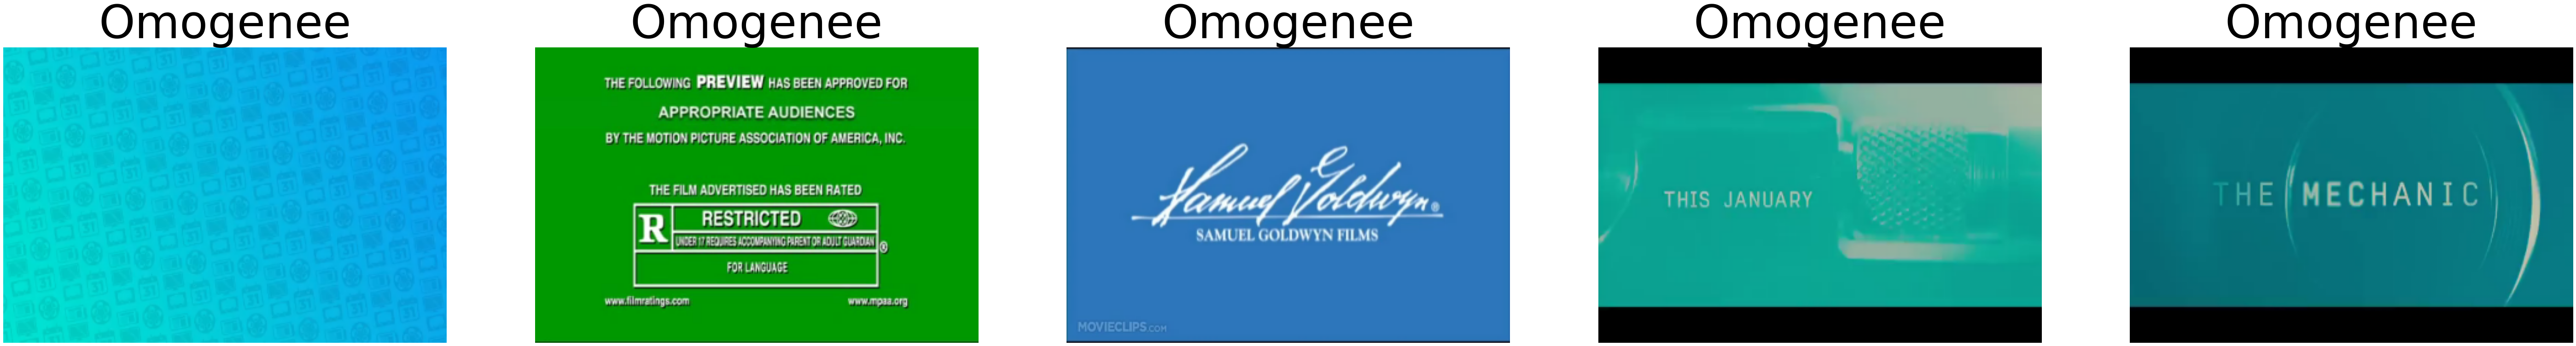

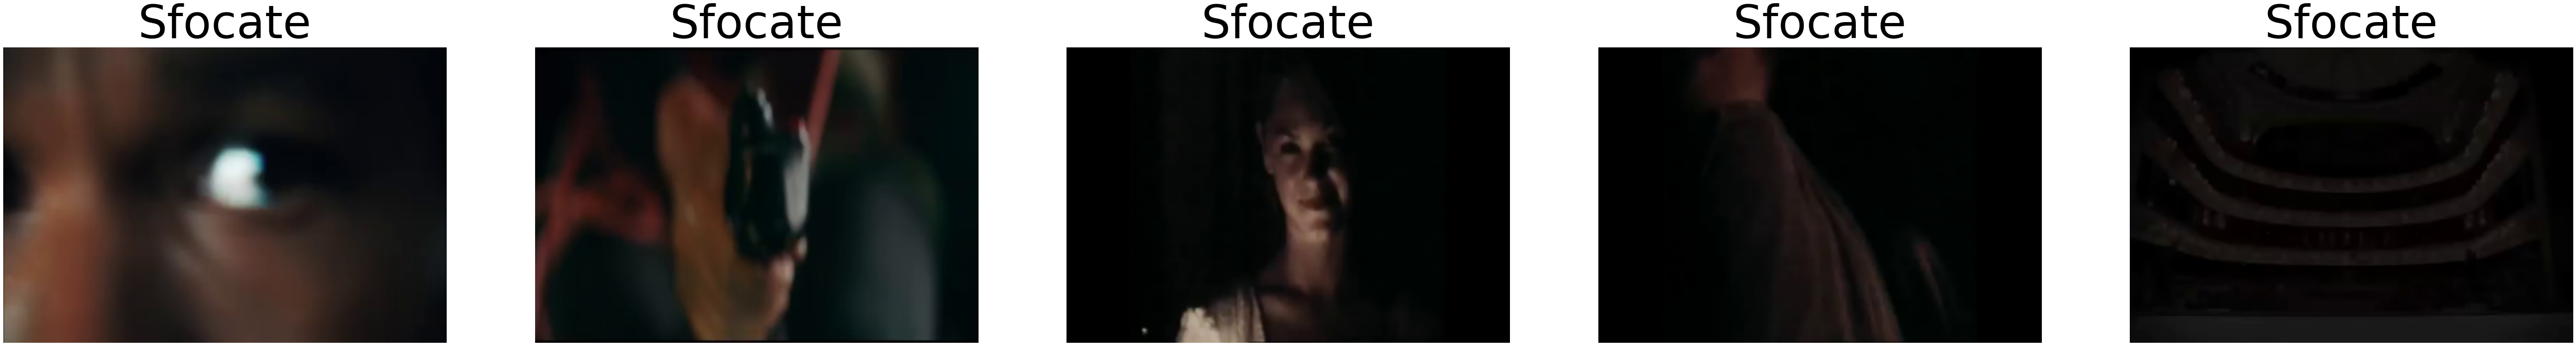

In [ ]:
fig = plt.figure(figsize=(100, 100))
i=1
for imgOmog in listaOmogenee:
  fig.add_subplot(1, 5, i)
  plt.imshow(imgOmog)
  plt.axis('off')
  plt.title("Omogenee",fontsize=100)
  i+=1
plt.show()

fig = plt.figure(figsize=(100, 100))
i=1
for imgSfoc in listaSfocate:
  fig.add_subplot(1, 5, i)
  plt.imshow(imgSfoc)
  plt.axis('off')
  plt.title("Sfocate",fontsize=100)
  i+=1
plt.show()

Dopo aver eliminato le immagini che portavano poca informazioni andiamo a controllare se alcuni trailer sono rimasti vuoti.

In [ ]:
cartelle=os.listdir(DATASET_DIR)
listaTrailerVuoti=[]
contaTrailer=0

for c in cartelle:
  if os.path.isfile(DATASET_DIR+"/"+c):
    continue

  contaTrailer+=1
  if len(os.listdir(DATASET_DIR+"/"+c)) == 0:
    
    listaTrailerVuoti.append(c)
   


print("Numero Trailer Totali: ",contaTrailer)
print(f"# Trailer Vuoti= {np.array(listaTrailerVuoti).shape[0]}")
print(listaTrailerVuoti)





Numero Trailer Totali:  5404
# Trailer Vuoti= 0
[]


Da come si può notare tutto procede normalmente perchè tutti i trailer hanno almeno 1 immagine

##Calcolo di Limit

In questa sezione andiamo a capire qual'è il numero perfetto di frame da analizzare per ciascun trailer quindi il numero di frame da passare alla nostra rete neurale.

Calcoliamo la **media** dei frame per ciascun Trailer

In [ ]:
cartelle=os.listdir(DATASET_DIR)

media=0;
indice=1;

listaElementiPerTrailer=[]


for c in cartelle:
  if os.path.isfile(DATASET_DIR+"/"+c):
    continue
  listaElementiPerTrailer.append(len(os.listdir(DATASET_DIR+"/"+c)))
  media+=len(os.listdir(DATASET_DIR+"/"+c))
  indice+=1




print("Media di frame tra tutti i trailer: ",media//indice)



Media di frame tra tutti i trailer:  17


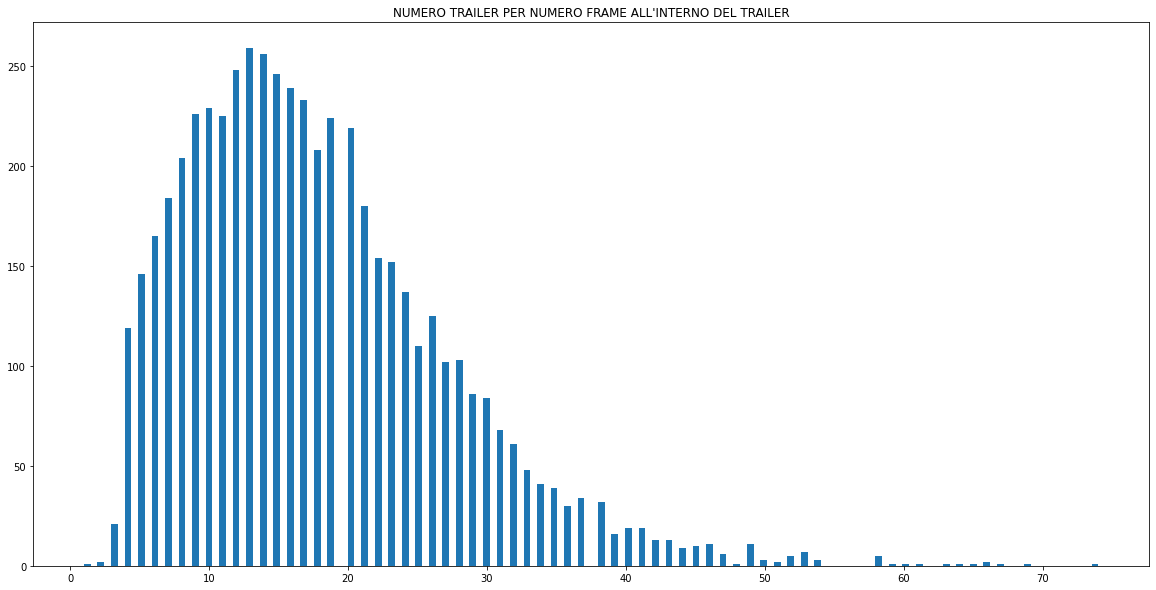

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(listaElementiPerTrailer,bins=150)
plt.title("NUMERO TRAILER PER NUMERO FRAME ALL'INTERNO DEL TRAILER")
plt.show()

Dal grafico si può evincere che la maggior parte di Trailer ha un numero di frame compresi tra 10 e 20. Per cui settiamo come limite di immagini per trailer il numero 10.

## Selezione Frame Migliori

In questa sezione andremo a descrivere 2 algoritmi che ci permettono di scegliere i frame migliori da processare per ciascun Trailer

**ritornaImmaginiMigliori()**  è un metodo che viene chiamato quando stiamo caricando un trailer che contiene più di 10 frame al suo interno.

Quello che fa è sostanzialmente ritornare tra l'insieme dei frame i 10 frame più buoni di quel particolare Trailer.

In particolare visto che stiamo parlando di un video abbiamo pensato che la scelta delle 10 immagini deve comunque essere consecutiva e non può avvenire in maniera random perchè altrimenti si andrebbe a perdere il senso  logico del film.

L'algoritmo prende le prime 10 immagini e le confronta con altre 10 immagini che sono le precedenti solamente che traslate di uno a destra. Una volta presi i due array d'immagini si calcola per ciascuno il valore di sfocatura e di omogeneeta con gli algoritmi descritti precedentemente ma con soglie ancora più profonde.

Per ciascun array si contano le immagini che superano queste soglie e l'array che contiene più immagini in questo modo viene scartato e si passa al confronto con un altro  array di 10 immagini e cosi via fino a selezionare le 10 migliori.


In [ ]:
def ritornaImmaginiMigliori(images):

  top15=images[0:limit]
  
  for i in range(1,len(images)):
    if (i+limit) <len(images):
       lista=images[i:(i+limit)]
    else:
      break

    top15=confrontaLeDue(top15,lista)
    
  return top15


def confrontaLeDue(lista1,lista2):



  soglia=88 #valore di soglia per l'immagine omogeenee
  thresh=15 #valore di soglia per la sfocatura
  
  numeroPerLista1=0
  numeroPerLista2=0




  for i in range(0,len(lista1)):
    
    image1=Image.fromarray(lista1[i])
    image2=Image.fromarray(lista2[i])
  

    #PER LISTA 1 
    ar = np.asarray(image1)*255
    gray = cv2.cvtColor(ar, cv2.COLOR_RGB2GRAY)*255

    

    
    fm = variance_of_laplacian(gray)
    r=np.average(ar[:,:,0])
    g=np.average(ar[:,:,1])
    b=np.average(ar[:,:,2])
    



    if r-g >soglia or r-b>soglia:
     
      numeroPerLista1+=1


    elif g-r >soglia or g-b>soglia:
   
      numeroPerLista1+=1
    
     
    elif b-r >soglia or b-g>soglia:
     
      numeroPerLista1+=1
      
    elif fm < thresh:
       
       numeroPerLista1+=1


    
    #PER LISTA 2 
    ar = np.asarray(image2)
    gray = cv2.cvtColor(ar, cv2.COLOR_RGB2GRAY)
    fm = variance_of_laplacian(gray)



    
  
    r=np.average(ar[:,:,0])
    g=np.average(ar[:,:,1])
    b=np.average(ar[:,:,2])


    if r-g >soglia or r-b>soglia:
      numeroPerLista2+=1


    elif g-r >soglia or g-b>soglia:
      numeroPerLista2+=1
    
     
    elif b-r >soglia or b-b>soglia:
      numeroPerLista2+=1
      
    elif fm < thresh:
      numeroPerLista2+=1
  
  if numeroPerLista1>numeroPerLista2:
  
    return lista2

  return lista1

    


**duplicaImmagini()** invece è un semplice algoritmo che viene utilizzato per quei Trailer che hanno meno di 10 frame. In maniera tale da portarli ad avere 10 immagini duplicando le immagini già presenti al suo interno, utilizzando però lo stessa tecnica descritta precedentemente, cioè replicando le immagini in sequenza in maniera tale da non perdere il senso del film. Inoltre visto che si sta effettuando una duplicazione abbiamo scelto di duplicarli in una certa maniera,attuando delle trasformazioni, del tipo una rotazione di 30 gradi e un ColorJitter(). 

In [ ]:
def duplicaImmagini(immagini,base,limite):

  transformations = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(),
                                                    torchvision.transforms.RandomRotation(degrees=30),
                                                    torchvision.transforms.ColorJitter(),
                                                    torchvision.transforms.ToTensor(),
                                                  ])

  while base<limite:
    for img in immagini:
      
      if base<limite:
        immagini[base]=transformations(img).unsqueeze(0)
        base+=1
        
       

  
  return immagini



Applichiamo , le trasformazioni solamente alle immagini duplicate per far credere alla rete che siano delle immagini diverse da processare di uno stesso trailar

In [ ]:
it=iter(trainingDataLoader)
trailer1,lab,c=next(it)
trailer1,lab,c=next(it)
trailer1,lab,c=next(it)
trailer1,lab,c=next(it)

In [ ]:
trailer1,lab,c=next(it)

CASO IN CUI AVVIENE LA DUPLICAZIONE PERCHE' NUMERO DI IMMAGINI IN TRAILER MINORE DI LIMIT


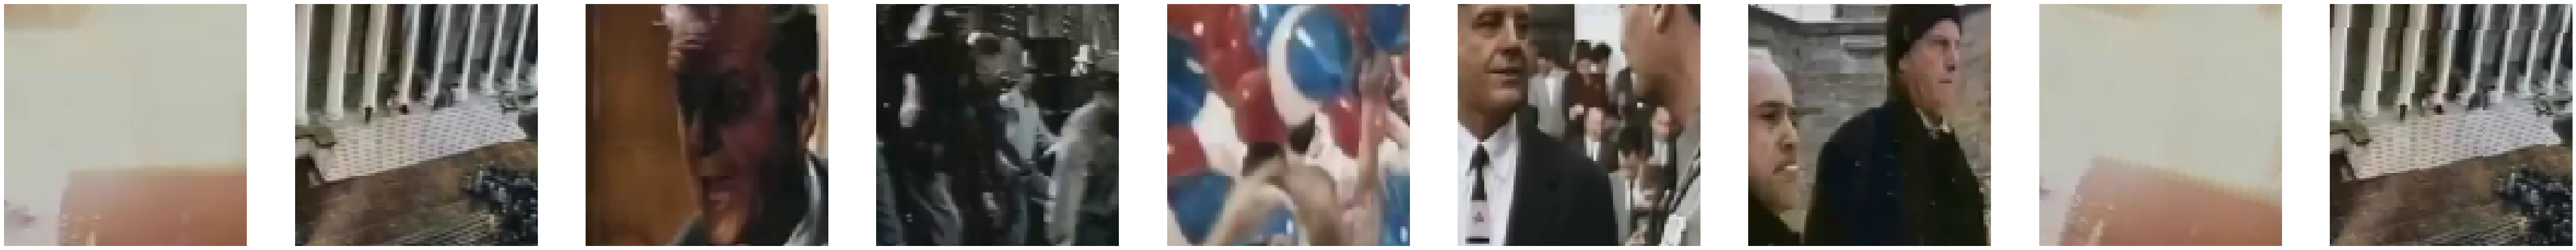

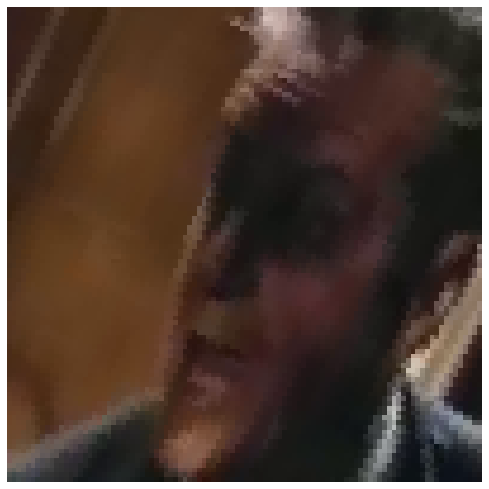



CASO IN CUI VENGONO SCELTE LE LIMIT IMMAGINI MIGLIORI SE SONO PIU' DI LIMIT


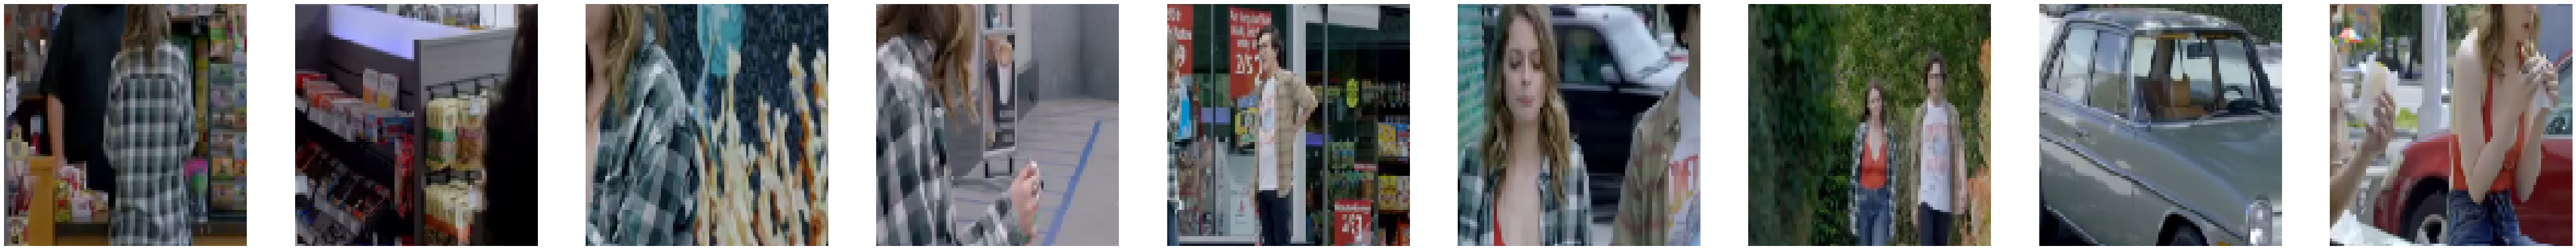

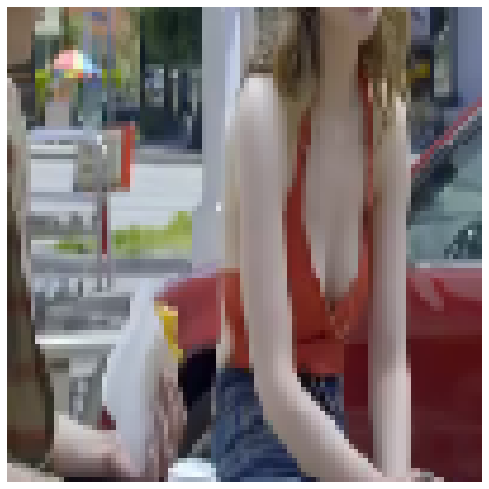

In [ ]:
print("CASO IN CUI AVVIENE LA DUPLICAZIONE PERCHE' NUMERO DI IMMAGINI IN TRAILER MINORE DI LIMIT")

trailer=trailer1[26]



fig = plt.figure(figsize=(80, 80))

i=1



for img in trailer:
  
  if i<10:
    fig.add_subplot(1,9,i)
    plt.imshow(np.clip(img.numpy().transpose(1,2,0),0,1))
    plt.axis('off')
    i+=1
    continue
   
  elif i==10:
    plt.show()
    fig = plt.figure(figsize=(80, 80))

  if i>=10:
    fig.add_subplot(1,8,i-9)
    plt.imshow(np.clip(img.numpy().transpose(1,2,0),0,1))
    plt.axis('off')
    i+=1

plt.show()

print()
print()
print("CASO IN CUI VENGONO SCELTE LE LIMIT IMMAGINI MIGLIORI SE SONO PIU' DI LIMIT")

trailer=trailer1[13]

fig = plt.figure(figsize=(80, 80))

i=1



for img in trailer:
  
  if i<10:
    fig.add_subplot(1,9, i)
    plt.imshow(np.clip(img.numpy().transpose(1,2,0),0,1))
    plt.axis('off')
    i+=1
    continue
   
  elif i==10:
    plt.show()
    fig = plt.figure(figsize=(80, 80))

  if i>=10:
    fig.add_subplot(1,8,i-9)
    plt.imshow(np.clip(img.numpy().transpose(1,2,0),0,1))
    plt.axis('off')
    i+=1

plt.show()
   
   


## Caricamento Dati

In [ ]:
from torchvision.utils import save_image
limit=10
class VideoDataset(Dataset):

    #cache utilizzate per salvare tutte le operazioni fatte nella prima epoca per le immagini per evitarle di ricalcolare ogni volta.
    cacheImgMigliori=None
    train=True
    



    def __init__(self, dataset_folder, labels_dict, transform=None, limit=10,train=True):
        """
        Args:
            dataset_folder (string): Path to the folder with mp4 files.
            labels_dict (dict): dict filename - list of label.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_dict = labels_dict
        self.root_dir = dataset_folder
        self.limit = limit
        self.train=train
  
     
      
        if self.train:  
          self.cacheImgMigliori=load_ImgMigliori() or None
          if self.cacheImgMigliori==None:
              print("Sto creando la Cache per DatasetTrain")
              os.mkdir('/content/drive/MyDrive/ProgettoAnalisiImmagini/progetto_2021_saves/cacheDatasetTrain')
          else:
              print("Utilizzo Cache Esistente DatasetTrain")
          

     

        self.transform = transform or torchvision.transforms.ToTensor()
   
      
 
        self._files = np.array(list(self.labels_dict.keys()))
   

    def __len__(self):
        return len(self.labels_dict)

    def __getitem__(self, idx):
          #Nome Cartella Trailer
          name = self._files[idx]
         

            
          #calcolo etichette per trailer
           
          labels = torch.zeros(len(label_idx), dtype=torch.float32)
          for label in self.labels_dict[name]:
            labels[label_idx[label]] = 1
            

         
          
          images=""

          #utilizzo per evitare di rieseguire gli stessi calcoli alle prossime epoche
          if self.cacheImgMigliori is not None:
            #prendo i dati dalla cache
            folder_pattern = os.path.join(self.cacheImgMigliori,name, '*.png')
            images = io.imread_collection(folder_pattern)
            #controllo in caso si sia arrestato prima la creazione della cache 
            if len(images)!=limit:
              self.cacheImgMigliori=None
              images = io.imread_collection(os.path.join(self.root_dir, name, '*.png'))
          
          else:
            #prendo i dati dalla memoria normale
            folder_pattern = os.path.join(self.root_dir, name, '*.png')
            images = io.imread_collection(folder_pattern)
          
            
          x = torch.zeros(self.limit, 3, 100, 100)

         
          #metodo che serve per ritornare le immagini migliori in caso il trailer contenga + di limit immagini
          if len(images)>limit and self.train: #non lo esegue in caso siano state caricate dalla cache perchè len=10
             
              images=ritornaImmaginiMigliori(images)

          
         
        
          for i, image in enumerate(images):
              if i < self.limit:
                  image = self.transform(Image.fromarray(image))
                  x[i] = image.unsqueeze(0)
                  
         


          #metodo che duplica le immagini in caso in cui un trailer contiene - di limit immagini
          if len(images)<limit and self.train: #non lo esegue in caso siano state caricate dalla cache perchè len=10
             
              x=duplicaImmagini(x,len(images),limit)

       
          #caso in cui stiamo creando la cache salvo l'intero tensore di immagini migliori per un Trailer
          if self.cacheImgMigliori is None and self.train:
              os.mkdir('/content/drive/MyDrive/ProgettoAnalisiImmagini/progetto_2021_saves/cacheDatasetTrain/'+name)
              i=0
              for img in x:
                save_image(img,'/content/drive/MyDrive/ProgettoAnalisiImmagini/progetto_2021_saves/cacheDatasetTrain/'+name+'/'+str(i)+'.png')
                i+=1
       
          
          
          return x, labels,name
        
transformationsTrain = torchvision.transforms.Compose([
                                                       torchvision.transforms.CenterCrop(100),
                                                       torchvision.transforms.ToTensor(),
                                                       
                                                       ])



transformationsTest = torchvision.transforms.Compose([ torchvision.transforms.CenterCrop(100),
                                                       torchvision.transforms.ToTensor(),
                                                        ])


datasetTrain = VideoDataset(DATASET_DIR, newDiz ,transformationsTrain,limit,True)
datasetTest = VideoDataset(DATASET_DIR, dataset_json['test'], transformationsTest,limit,False)


Utilizzo Cache Esistente DatasetTrain


In [ ]:
batch_size = 29

trainingDataLoader = torch.utils.data.DataLoader(datasetTrain, 
                                                batch_size=batch_size, 
                                                shuffle=True
                                                 )

testDataLoader = torch.utils.data.DataLoader(datasetTest, 
                                             batch_size=batch_size, 
                                             shuffle=False
                                             )




In [ ]:
trainSize=len(datasetTrain)
testSize=len(datasetTest)
print("TRAIN SIZE: ",trainSize,"NUMERO DI BATCH:",len(trainingDataLoader))
print("TEST SIZE: ",testSize,"NUMERO DI BATCH:",len(testDataLoader))


TRAIN SIZE:  3914 NUMERO DI BATCH: 135
TEST SIZE:  1112 NUMERO DI BATCH: 39


VideoDataset2 viene utilizzato per effettuare l'addestramento oppure la fase di test in maniera più efficente possibile prelevando non più le immagini per i vari trailer ma i vettori delle feature associati salvati e creati durante una prima fase di addestramento o di test

In [13]:
class VideoDataset2(Dataset):


    def __init__(self, dataset_folder, labels_dict,dizFeature):
        """
        Args:
            dataset_folder (string): Path to the folder with mp4 files.
            labels_dict (dict): dict filename - list of label.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_dict = labels_dict
        self.root_dir = dataset_folder
        self._files = np.array(list(self.labels_dict.keys()))
        self.dizFeature=dizFeature


    def __len__(self):
        return len(self.labels_dict)

    def __getitem__(self, idx):
          name = self._files[idx]
  
          

          lab = torch.zeros(len(label_idx), dtype=torch.float32)
          for label in self.labels_dict[name]:
            lab[label_idx[label]] = 1

          feat=self.dizFeature[name]/10
          
          return feat,lab


datasetTrainOttimizzato = VideoDataset2(DATASET_DIR, newDiz ,load_dizFeature(True))
datasetTestOttimizzato = VideoDataset2(DATASET_DIR, dataset_json['test'] ,load_dizFeature(False))


In [14]:
batch_size = 29

trainingDataLoaderOttimizzato = torch.utils.data.DataLoader(datasetTrainOttimizzato, 
                                                batch_size=batch_size, 
                                                shuffle=True
                                                 )

testDataLoaderOttimizzato = torch.utils.data.DataLoader(datasetTestOttimizzato, 
                                                batch_size=batch_size, 
                                                shuffle=False
                                                 )

In [ ]:
trainSize=len(datasetTrainOttimizzato)
testSize=len(datasetTestOttimizzato)
print("TRAIN SIZE:",trainSize,"NUMERO DI BATCH:",len(trainingDataLoaderOttimizzato))
print("TEST SIZE: ",testSize,"NUMERO DI BATCH:",len(testDataLoaderOttimizzato))

TRAIN SIZE: 3914 NUMERO DI BATCH: 135
TEST SIZE:  1112 NUMERO DI BATCH: 39


# Modello 

Il nostro modello è composto da:  


* 1 livello (feature) di una Vgg16 pre-Addestrata che ci permette di calcolare le featureMap per ogni trailer.

* 2 livello (feature) di una ResNet50 pre-Addestrata che ci 
permette di calcolare le featureMap per ogni trailer.

* 3 livello fully-connected composto da dei livelli lineare per effettuare la classificazione.





In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def test(net,img_size=52):
    x = torch.randn(1,3,img_size,img_size)
    y = net(x)

    print("Input: {}; Output: {}; N. of params: {:,}".format(list(x.size()), list(y.size()), count_parameters(net)))

Carichiamo i modelli e freeziamo i gradienti dei loro tensori per evitare di addestrarli perchè si effettua il TrasferLearning

In [15]:
from torchvision import models
from torch import optim, cuda

vgg = models.vgg16(pretrained=True, progress=False)

resNet = models.resnet50(pretrained=True, progress=False)


for param in vgg.parameters():
    param.requires_grad = False


for param in resNet.parameters():
    param.requires_grad = False


vgg.classifier=nn.Sequential()
resNet.fc=nn.Sequential()


vgg = vgg.to(device)
resNet=resNet.to(device)


print(resNet)




ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
print("VGG")
test(vgg,52)
print("ResNet50")
test(resNet,64)

VGG
Input: [1, 3, 52, 52]; Output: [1, 25088]; N. of params: 0
ResNet50
Input: [1, 3, 64, 64]; Output: [1, 2048]; N. of params: 23,508,032


Il modello è stato costruito in maniera tale da potergli passare un input composto da 5 dimensioni che sono:

*   BatchDize,numImgTrailer,Canali,H,W

una volta chiamato il metodo forward viene eseguito un reshape del tensore x passato per portarlo a 4 dimensioni eseguendo questo calcolo

*   BatchSize*numImgTrailer,canali,H,W

una volta ottenuto il tensore a 4 dimensioni lo passiamo ai livelli che ci estrapolano le featureMap tramite la Vgg16 la ResNet50, chiamati **featureVgg,featureResNet**.
L'output ottenuto da questi livelli è un tensore di 4 dimensioni che viene trasformato in questa maniera.

*   BatchSize,numImgTrailer,Feature

Per aggregare tutte le feature prodotte per ciascun trailer abbiamo deciso di eseguire la media delle feature.Producendo cosi un tensore del seguente tipo

*   BatchSize,FeatureTotali

sia per le feature prodotte dalla Vgg16 sia per quelle della ResNet50.

Infine una volta ottenuti i due tensori delle feature li abbiamo concatenati uno con l'altro creando un tensore unico.

Tensore unico che viene passato al livello **classifier** della rete che ci permette di predire le 85 classi/tag.Tornando un tensori di

*   BatchSize,85





In [16]:
import torch.nn.functional as F


class AzGmNet(nn.Module):
    def __init__(self):
        super(AzGmNet, self).__init__()
        
        self.featureVgg=vgg.features
         
        self.featureResNet=resNet.forward
        


        self.classifier = nn.Sequential(
            nn.Linear(6656 , 1024),
            nn.ReLU(True),
            nn.Linear(1024 , 1024),
            nn.ReLU(True),
            nn.Linear(1024 , 85),
          
            
        )

        

    def forward(self, x):
        #x(Batch size, numImgTrailer,Canali,H,W). y(batchSize,85).

        #(batch*numImgTrailer,canali,H,W)
        xNew=x.view(x.shape[0]*x.shape[1],x.shape[2],x.shape[3],x.shape[4])
        xNew=xNew.to(device)


        outputFeatureResNet=self.featureResNet(xNew)
        outputFeatureVgg=self.featureVgg(xNew)
   
      

        
        #(batch,numImgTrailer,Feature)      
        outputFeatureVgg=outputFeatureVgg.view(x.shape[0],x.shape[1],-1)
        outputFeatureResNet=outputFeatureResNet.view(x.shape[0],x.shape[1],-1)

    

        #(batch,FeatureTotali)
        fmTotVgg=torch.zeros((outputFeatureVgg.shape[0],outputFeatureVgg.shape[2])).to(device)
        fmTotResNet=torch.zeros((outputFeatureResNet.shape[0],outputFeatureResNet.shape[2])).to(device)
        

        for i in range(0,outputFeatureVgg.shape[0]):
          fmTotVgg[i,:]=outputFeatureVgg[i,:,:].sum(dim=0) #MEDIA DELLE FEATURE DI OGNI TRAILER
          fmTotResNet[i,:]=outputFeatureResNet[i,:,:].sum(dim=0) #MEDIA DELLE FEATURE DI OGNI TRAILER
             
        fmTot = torch.cat((fmTotVgg,fmTotResNet),1)

        output= self.classifier(fmTot)

        return output,fmTot
  
    

In [17]:
model=AzGmNet()
model=model.to(device)

optimizer = optim.Adam(model.parameters())



## Loss

Come analizzato precedentemente abbiamo deciso di utilizzare una Loss pesata che ci permetta di diminure e di gestire al massimo lo sbilanciamento che abbiamo tra le classi.



Dando Peso alto sulle classi meno frequenti e basso nelle più frequenti.

Utilizzando come formula 1/sqrt(totale)

dove totale è il numero di trailer per un particolare tag



In [18]:
weight=1/torch.sqrt(totale)

print("Numerosità tag rispetto alle classi")
print()
print(totale)
print()
print("Peso associato alla classe in base alla numerosità")
print()
print(weight)

Numerosità tag rispetto alle classi

tensor([265., 717.,  22., 294.,  25.,  45.,  92.,  84.,  70., 232.,  32.,  67.,
         47., 773., 269.,  39.,  33., 515.,  31.,  25.,  24.,  44., 114., 755.,
         81.,  29.,  69.,  61., 358.,  47.,  24.,  76.,  29.,  36.,  64., 502.,
         86.,  31.,  25.,  25.,  69.,  36.,  68.,  32.,  80.,  47.,  40., 236.,
        222.,  71., 106.,  53.,  31.,  24.,  37.,  54.,  16.,  58.,  20.,  27.,
         79., 413., 294., 436.,  92.,  93.,  29.,  65.,  89.,  46.,  31.,  98.,
         25.,  53.,  78.,  66., 554.,  49.,  29.,  49.,  82., 222., 221., 109.,
         62.])

Peso associato alla classe in base alla numerosità

tensor([0.0614, 0.0373, 0.2132, 0.0583, 0.2000, 0.1491, 0.1043, 0.1091, 0.1195,
        0.0657, 0.1768, 0.1222, 0.1459, 0.0360, 0.0610, 0.1601, 0.1741, 0.0441,
        0.1796, 0.2000, 0.2041, 0.1508, 0.0937, 0.0364, 0.1111, 0.1857, 0.1204,
        0.1280, 0.0529, 0.1459, 0.2041, 0.1147, 0.1857, 0.1667, 0.1250, 0.0446,
        0.1078,

Una volta stabiliti i pesi , abbiamo deciso di utilizzare una **BCEwithLogitsiLoss** come loss del modello perchè dobbiamo effettuare una classificazione multilabel e inoltre scegliere le top 10 classi migliori percui dobbiamo associare a ciascuna delle 85 classi predette per ogni trailer una probabilità attraverso l'utilizzo della Sigmoide cosa che è inclusa gia nella BCEwithLogitsLoss.

In [19]:
criterion=nn.BCEWithLogitsLoss(weight=weight)

# Train

In [ ]:
epochs = 6
train_losses=[]


salvaDizionario={}
#<NomeCartella,Feature>
dizionarioFeature=load_dizFeature(True) or {}

print()
print()

try:
    for epoch in range(0, epochs):
      print('Start epoch', epoch+1)
      model.train()
      steps = 0
      batch=0;
    
      #x(Batch size, numImgTrailer,Canali,H,W).     y(batchSize,85).
      avarageLoss=0
      
      for x, y,nomiCartelle in trainingDataLoader:


        nomiCartelle=np.array(nomiCartelle)
        
        y=y.to(device)
        steps += 1
        
        optimizer.zero_grad()


        #salvataggio feature per ottimizzare velocità rete
        if dizionarioFeature=={}:
          logit,feature= model(x)
          for i in range(0,feature.shape[0]):
            salvaDizionario[nomiCartelle[i]]=feature[i]
          
        else:
            feature=dizionarioFeature[nomiCartelle[0]]
            for i in range(1,nomiCartelle.size):
              feature=torch.cat((feature,dizionarioFeature[nomiCartelle[i]]),0)
            feature=feature.view(x.shape[0],-1).to(device)
            logit=model.classifier(feature)
        

        loss = criterion(logit, y)
        loss.backward()
        optimizer.step()
        avarageLoss+=loss.item()

    
        print(f"epoch {epoch+1}/{epochs} "
        f"train loss for batch {batch}: {loss.item():.6f} ")
        batch+=1

        if steps%10 == 0:
          train_losses.append(avarageLoss/steps)

      save_checkpoint(epoch, model, optimizer, avarageLoss/steps)
      save_traningLoss(train_losses)
      
      if dizionarioFeature=={}:
        save_dizFeature(salvaDizionario,True)
        dizionarioFeature=load_dizFeature(True) or {}

      

      print("!!!!CheckPoint Salvato!!!!!")  
      print(f"Epoch {epoch+1}/{epochs}... "
                  f"Train loss: {avarageLoss/steps:.3f}... ")
      
     
          

except KeyboardInterrupt: 
    print('Exiting from training early')


save_model(model)


#Epoch 1/10... Train loss: 0.002... 

# Train Ottimizzato


In [25]:
model=AzGmNet()
model=model.to(device)

optimizer = optim.Adam(model.parameters())

criterion=nn.BCEWithLogitsLoss(weight=weight)

In [26]:
#TRAIN OTTIMIZZATO


epochs = 6
train_losses=[]

print()
print()

try:
    for epoch in range(0, epochs):
      model.train()
      steps = 0
      batch=0;
    
      #x(Batch size, numImgTrailer,Canali,H,W).     y(batchSize,85).
      avarageLoss=0
      
      for feat,y in trainingDataLoaderOttimizzato:

        y=y.to(device)
        steps += 1
        feat=feat.to(device)
        
        optimizer.zero_grad()


        logit=model.classifier(feat)
        

        loss = criterion(logit, y)
        loss.backward()
        optimizer.step()
        avarageLoss+=loss.item()

    
        #print(f"epoch {epoch+1}/{epochs} "
        #f"train loss for batch {batch}: {loss.item():.6f} ")
        #batch+=1

        #if steps%10 == 0:
        train_losses.append(avarageLoss/steps)

      
      

      
      print(f"Epoch {epoch+1}/{epochs}... "
                  f"Train loss: {avarageLoss/steps:.8f}... ")
       
      save_checkpoint(epoch, model, optimizer, avarageLoss/steps)
      print("!!!!CheckPoint Salvato!!!!!") 
      save_traningLoss(train_losses)
      print()
    
      

except KeyboardInterrupt: 
    print('Exiting from training early')

#save_model(model)








Epoch 1/6... Train loss: 0.01292616... 
!!!!CheckPoint Salvato!!!!!
 !!Traning Loss Salvata!!

Epoch 2/6... Train loss: 0.01107269... 
!!!!CheckPoint Salvato!!!!!
 !!Traning Loss Salvata!!

Epoch 3/6... Train loss: 0.01068832... 
!!!!CheckPoint Salvato!!!!!
 !!Traning Loss Salvata!!

Epoch 4/6... Train loss: 0.01049386... 
!!!!CheckPoint Salvato!!!!!
 !!Traning Loss Salvata!!

Epoch 5/6... Train loss: 0.01021336... 
!!!!CheckPoint Salvato!!!!!
 !!Traning Loss Salvata!!

Epoch 6/6... Train loss: 0.00991906... 
!!!!CheckPoint Salvato!!!!!
 !!Traning Loss Salvata!!



# Plot loss

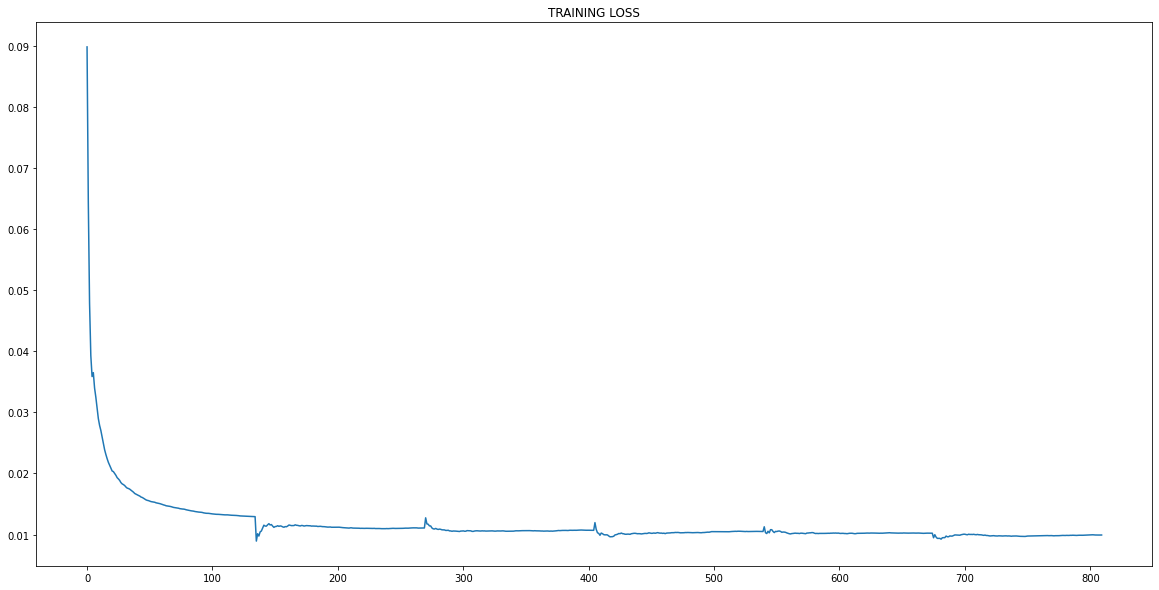

In [27]:
trainLossesModel=load_traningLoss()
plt.figure(figsize=(20,10))
plt.plot(trainLossesModel)
plt.title("TRAINING LOSS")
plt.show()